In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from concentrations import concentrations_generator as cg
import ribosomesimulator as r

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
#get the stored reaction propensities from the ribosome simulator
sim = r.ribosomesimulator()
props = sim.getPropensities()
w6f_ref = props['wobble6f']
wdiss_ref = props['wobblediss']

In [3]:
#prepare list of codons to be modelled
model_codons = []
for n1 in ['A','C','G','U']:
    for n2 in ['A','C','G','U']:
        for n3 in ['A','C','G','U']:
            codon = n1+n2+n3
            if codon not in ['UAA','UAG','UGA']:
                model_codons.append(codon)

In [8]:
#prepare the required invariant parameters

codon_list = pd.read_csv('tRNA data/codon.csv')
tRNAs = pd.read_csv('tRNA data/N_GCN_Scer.csv')
matrix = cg.make_matrix(tRNAs, codon_list, settings_file_name='default_basepairing.json')
concs = cg.make_concentrations(matrix, tRNAs, codon_list, concentration_col_name='Seq').to_csv(path_or_buf = None)
sim.loadConcentrationsFromString(concs)

In [9]:
#systematically vary wobble6f and wobblediss and record predicted decoding times
factors = [1,2,3,4]
result_list = []
for factor in factors:
    sim = r.ribosomesimulator()
    sim.loadConcentrationsFromString(concs)
    print(factor)
    props['wobblediss'] = wdiss_ref*factor
    sim.setPropensities(props)
    run_results = []
    for codon in model_codons:
        sim.setCodonForSimulation(codon)
        run_results.append(sim.run_repeatedly_get_average_time(10000))
    result_list.append(run_results)
#add run with modified rate constants ie 130 and 90
sim = r.ribosomesimulator()
sim.loadConcentrationsFromString(concs)
print('updated')
props['wobblediss'] = 90
props['wobble6f'] = 120
run_results = []
for codon in model_codons:
    sim.setCodonForSimulation(codon)
    run_results.append(sim.run_repeatedly_get_average_time(10000))
result_list.append(run_results)
df = pd.DataFrame({'codon':model_codons})
factors += ['updated']
for idx,f in enumerate(factors):
    df[factors[idx]] = result_list[idx]

1
2
3
4
updated


In [19]:
#add RRTs to df
combined_data =pd.DataFrame(df['codon'])
for colname in df.columns[1:]:
    colmean = np.mean(df[colname])
    combined_data[colname] = df[colname] / colmean
rrt_filenames = os.listdir('Codon data/')
for rrt_filename in rrt_filenames:
    if rrt_filename[0] != '.':
        new_data = pd.read_csv('Codon data/' + rrt_filename)
        new_name = rrt_filename[:-4]
        new_data.columns = ['codon',new_name]
        combined_data = combined_data.merge(new_data,on='codon')
combined_data = combined_data.set_index('codon')

In [20]:
combined_data.head()

,1,2,3,4,updated,Fang_2018,Gardin_2014,Weinberg_2016,Pop_2014,Bordignon_2021
codon,,,,,,,,,,
AAA,0.713339,0.668554,0.634336,0.606947,0.702614,0.818143,0.88,0.817614,1.264451,0.673518
AAC,0.505529,0.477494,0.442277,0.421240,0.496021,0.628564,0.76,0.576569,1.011561,0.381353
AAG,0.350172,0.335994,0.324037,0.305982,0.353315,0.795997,0.74,0.914622,1.180155,0.505395
ACA,0.539549,0.530138,0.517336,0.509128,0.532753,0.879736,1.35,1.107640,0.969990,0.720674
ACC,0.589364,0.596563,0.608014,0.614513,0.583601,0.619733,0.70,0.583098,0.769666,0.124042


In [23]:
#fit 2D mds
mds = MDS(n_components=2,normalized_stress='auto',metric=True)
mds_data = mds.fit_transform(combined_data.T)
get_mds_clusters = DBSCAN(eps=0.2, min_samples=10).fit(mds_data)

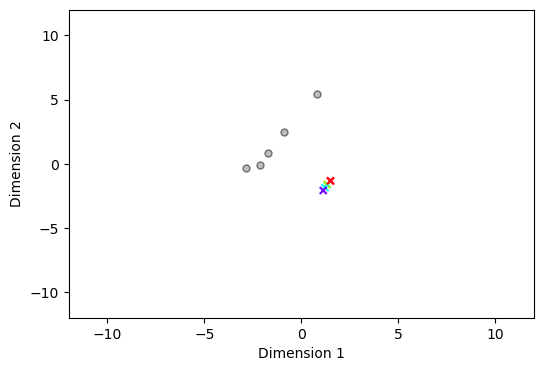

In [26]:
###Plot results

x = mds_data.T[0]
y = mds_data.T[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x[:5],y[:5],s=25,c=[1,2,3,4,5],cmap='hsv',marker='x')
ax.scatter(x[-5:],y[-5:],c='grey',edgecolor='black',s=25,alpha=0.5)
#label individual clusters with their cluster number
for n in range(max(get_mds_clusters.labels_)+1):
    select_x = [a[0] for i,a in enumerate(norm_mds_data) if get_mds_clusters.labels_[i] == n]
    select_y = [a[1] for i,a in enumerate(norm_mds_data) if get_mds_clusters.labels_[i] == n]
    ax.text(max(select_x) + 0.2,np.mean(select_y),str(n))
ax.set_xlim((-12,12))
ax.set_ylim((-12,12))
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
plt.savefig('tRNA dataset clusters.svg')
plt.show()
